In [1]:
import tributary as t
import pyEX as p
import pandas as pd

In [2]:
def sma_close(data):
    dat = [x['close'] for x in data]
    return sum(dat)/len(dat)
    
def crosses(state, data):
    sma_short = data[0]
    sma_long = data[1]

    if state.golden:
        # short moved above long
        if sma_short < sma_long:
            state.golden = False
    else:
        # long moved above short
        if sma_short > sma_long:
            state.golden = True
            
    # clean output data
    data = data[2]
    data['sma_short'] = sma_short
    data['sma_long'] = sma_long
    return data

In [9]:
def wrap(ticker):
    # data source
    data = t.Delay(t.UnrollDataFrame(p.Client(version="sandbox").chartDF(ticker, '3m')), .05)

    # windows
    window1 = t.Window(data, size=3, full_only=False)
    window2 = t.Window(data, size=20, full_only=False)

    # avgs
    sma1 = t.Apply(sma_close, window1)
    sma2 = t.Apply(sma_close, window2)

    # merge streams
    merged = t.Reduce(sma1, sma2, data)

    calc = t.Apply(t.State(crosses, golden=False), merged)
    # psp = t.Print(calc)
    psp = t.Perspective(calc, columns=['close', 'sma_short', 'sma_long'], plugin='y_line', row_pivots=['index'])
    return psp

In [10]:
run = []

# AAPL

In [11]:
run.append(wrap('aapl'))

PerspectiveWidget(columns=['close', 'sma_short', 'sma_long'], plugin='y_line', row_pivots=['index'])

# IBM

In [12]:
run.append(wrap('ibm'))

PerspectiveWidget(columns=['close', 'sma_short', 'sma_long'], plugin='y_line', row_pivots=['index'])

# TSLA 

In [13]:
run.append(wrap('tsla'))

PerspectiveWidget(columns=['close', 'sma_short', 'sma_long'], plugin='y_line', row_pivots=['index'])

In [16]:
def correlation(state, data):
    if state.dat is None:
        state.dat = []
    new = {s: data[i]['changePercent'] for i, s in enumerate(state.symbols)}
    state.dat.append(new)
    df = pd.DataFrame(state.dat)
    return df.corr()

reduced = t.Reduce(*run)
final = t.Perspective(t.Apply(t.State(correlation, dat=None, symbols=['aapl', 'ibm', 'tsla']), reduced), plugin='heatmap', columns=['aapl', 'ibm', 'tsla'], row_pivots=['index'], aggregates={'aapl':'last', 'ibm': 'last', 'tsla': 'last'})

PerspectiveWidget(aggregates={'aapl': 'last', 'ibm': 'last', 'tsla': 'last'}, columns=['aapl', 'ibm', 'tsla'],…

In [17]:
t.run(final)

TypeError: 'numpy.float64' object is not iterable

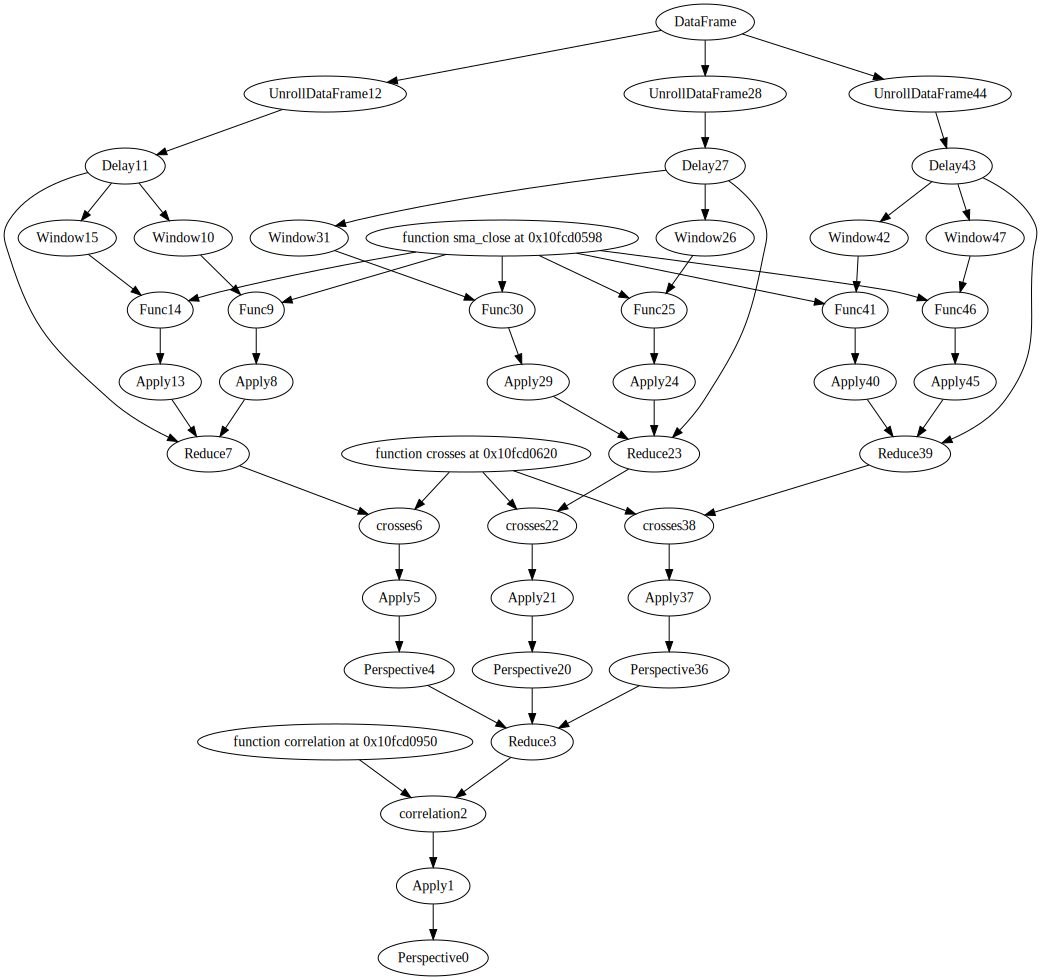

In [10]:
t.GraphViz(final)